# Finding Temporal Dependence on Databases
Joaquin Cuomo

## Functions

In [0]:
!pip install pymannkendall

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import os
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.tsa.arima_process as arima
import matplotlib.pyplot as plt
import numpy as np
import pymannkendall as mk
import zipfile
import numbers
from statsmodels.tsa.stattools import acf, pacf
import copy
from IPython.display import clear_output
clear_output()

In [0]:
def analyze(serie, lags=20, plot=True, verbose=False):
  '''
  Analysis a 1D series for autocorrelation.
  INPUT
  serie: numerical array to be analyzed
  lags: number of temporal lags up to where to test for autocorrelation
  plot: TRUE if you want to plot results
  OUTPUT
  test: TRUE if autocorrleation is both statistically and quantitative significant
  result: acumulation of all significant autocorrelations at different lags
  '''
  if len(serie)<lags: #if lags is larger than the length of the series it changes the value 
    lags = int(np.floor(len(serie)/2))
    
  _, p = acorr_ljungbox(serie, lags=lags) # ljung-box test, where p is the statitical significance for each lag
  
  acf_x, confint = acf(serie, nlags=lags, alpha=0.05, fft=False, unbiased=False) #autocorrelation function
  q_thrhld = 0.5  # quantitative threshold for considering an autocorrelation value in the analysis (not the same as statistically significant)
  s_thrhld = 0.05 # statistically significant threshold 
  # filters those acorr values not significants (both statistical and quantitative)
  signif = ((acf_x > (confint[:,1]-acf_x)) | (acf_x < (confint[:,0]-acf_x))) & ((acf_x > q_thrhld) | (acf_x < -q_thrhld))
  signif[0] = False # remove lag 0
  result = sum([np.abs(x) for x, y in zip(acf_x, signif) if y == True]) # acum of all autocorr

  if plot:
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4,figsize=(35,3))
    ax1.plot(serie) # plot series in time
    plot_acf(serie, lags=lags, ax=ax2); # plot autocorrelation
    plot_pacf(serie, lags=lags, ax=ax3); # plot partial autocorrelation
    ax4.stem(p, basefmt=" ", use_line_collection=True) # plot ljung-box test significance values
    ax4.plot([0,lags],[s_thrhld,s_thrhld],'r') # plot ljung-box test significance threshold
    print(mk.original_test(serie))
  test = any(p<s_thrhld) and any(signif) # True if there is any significant acorr
  return test, result 

def analyzeDB(df):
  '''
  Analysis a 2D database for autocorrelation in every column.
  INPUT
  df: panda dataframe
  OUTPUT
  cols: attributes with autocorrelation
  acum_corr: list of autocorrelation for each attribute
  '''
  columns = list(df) # name of each attribute
  test=[]
  acum_corr = []

  for i in columns: # for each attribute
    if np.issubdtype(df[i].dtype, np.number): # if it is numerical
      itest , iacum_corr = analyze(df[i], plot=False) # analyze it for acorr
      test = np.append(test, itest) # append the boolean result
      acum_corr = np.append(acum_corr, iacum_corr) # append the acorr value
    else: # if not just add as it does not have acorr
      test = np.append(test, 0)
      acum_corr = np.append(acum_corr, 0)

  cols = [x for x, y in zip(columns, test) if y == 1] # keep attributes with acorr
  acum_corr = [x for x, y in zip(acum_corr, test) if y == 1] # keep values with acorr
  if not acum_corr: #if none attribute had acorr create one with 0
    acum_corr = [0]
  return cols, acum_corr

def analyzeDB_attGrouping(df, verbose=False):
  '''
  Analysis a 2D database for autocorrelation in every column by grouping each column by same-value rows
  INPUT
  df: panda dataframe
  OUTPUT
  summary_df: panda datafram with [rows: list of attributes], [columns: metrics to evaluate temporal dependence]
    metrics=['% data','groups', 'avg_temp_att', 'std', 'avg_corr', 'max_corr'] (see paper for explanation)
  results: dictionary with [key:attributes][key:value in that attribute]=[list of attributes with acorr, list of attributes' acorrs]
  '''
  results = dict()

  for col in list(df): # for each column
    results[col] = dict() # create an entry in a dictionary
    for att in df[col].unique(): # for each unique value
      try:
        corr_att, corrs = analyzeDB(df.loc[df[col] == att]) # filter the df by that value and look for columns with acorr
        if corr_att and corrs: # if any was found
          results[col][att] = [corr_att, corrs] # add it to the dictionary
          if verbose:
            print("Attribute, value, length:",col, att, len(df.loc[df[col] == att]))
            print(corr_att)
            print(corrs)
      except:
        pass

  summary = copy.deepcopy(results) 
  
  for key, value in results.items(): # for each column and column values
    list_n_corr_att = []
    list_max_corr = [0]
    acum_grouping = 0
    for key2, value2 in value.items(): # for each column values and the columns with acorr
      _, c = value2
      list_n_corr_att = np.append(list_n_corr_att, len(c)) # append the count of columns with acorr
      list_max_corr = np.append(list_max_corr, np.max(c))  # append the max acorr
      acum_grouping += len(df.loc[df[key] == key2]) # acumulate the rows used
    # add to the dictionary for every column: % data used, groups, avg_temp_att, std, avg_corr, max_corr
    summary[key] = [int(100*acum_grouping/len(df)), len(list_n_corr_att), np.mean(list_n_corr_att), np.std(list_n_corr_att), np.mean(list_max_corr), np.max(list_max_corr)]

  # analyze the df without grouping
  t, c = analyzeDB(df) 
  #add the results to the dict
  summary['no-grouping'] = [100,1, len(t), 0, np.mean(c), np.max(c)]
  #create a dataframe
  summary_df = pd.DataFrame.from_dict(summary, orient='index', columns=['% data','groups', 'avg_temp_att', 'std', 'avg_corr', 'max_corr'])
  print("Most probable grouping attribute is:",summary_df[['avg_temp_att']].idxmax().item())
  return summary_df, results

def getTemporalAtt(df, result, summary, filter_att=None):
  '''
  Extract attributes with autocorrelation using analyzeDB_attGrouping() output
  INPUT
  df: panda dataframe
  result: second output from analyzeDB_attGrouping()
  summary: first output from analyzeDB_attGrouping()
  filter_att: if not specify it will use the one with higher average of temporal sequences detected
  OUTPUT
  output: panda datafram with [rows: list of attributes with autocorrelation when grouping by filter_att], 
                              [columns: % of unique values (in filter_att) that detected autocorrelation for that row-attribute]
  '''
  if filter_att==None: # if no filter attibute is given
    filter_att = summary[['avg_temp_att']].idxmax().item() # use the one with the highest average of temporal sequences detected
  print("Filter attibute", filter_att)
  groups = summary['groups'][filter_att] # get in how many groups autocorrelated attributes where found
  dicAttCount = dict()
  for key,value in result[filter_att].items(): # for each column value and list of attributes with acorr
    for a in value[0]: # for each attributes with acorr 
      if a not in dicAttCount: # if the attribute is not already in the dict
        dicAttCount[a] = 0 # initialize it with 0
      else:
        dicAttCount[a] +=1 # else increment the count
  for k in dicAttCount.keys(): # for each count
    dicAttCount[k] /= groups/100 # calculate the percentage
  #create the output dataframe
  output = pd.DataFrame.from_dict(dicAttCount, orient='index',columns=['Ocurrences [%]'])
  thr = np.mean(output['Ocurrences [%]'])-np.std(output['Ocurrences [%]']) #calculate a naive threshold
  print('Threshold =', thr)
  return output

## Set up Databases

In [0]:
#download some databases
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00235/household_power_consumption.zip
!wget https://www.kaggle.com/rajeevw/ufcdata/download
clear_output()

In [0]:
# set up kaggle to download their datasets
#you need to upload a kaggle.json file that can be get from the kaggle Account->API
!pip install -U -q kaggle
!mkdir -p ~/.kaggle
!rm kag* #if there was any previous file uploaded
from google.colab import files
files.upload()
!cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle.json


## Analyze simple time series

Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=47.35119492533284, Tau=1.0, s=499500.0, var_s=111277500.0, slope=1.0)


(True, 19.370087780087783)

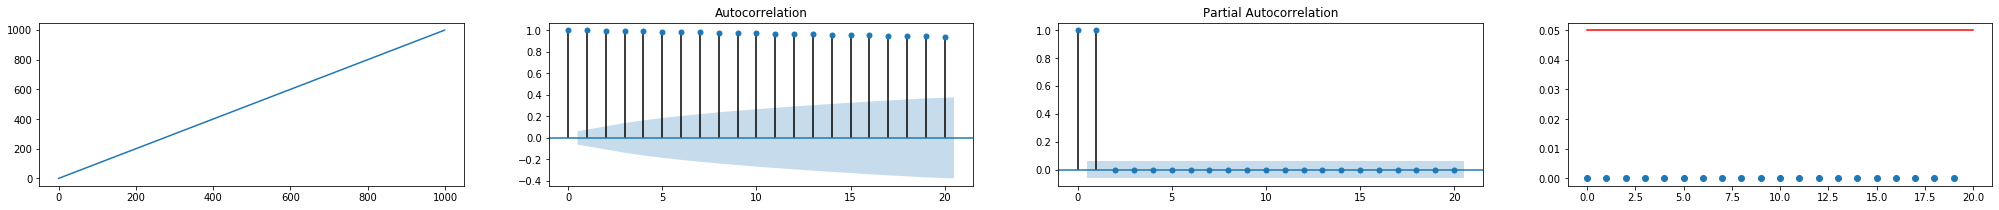

In [0]:
 analyze(np.arange(1000))

Mann_Kendall_Test(trend='no trend', h=False, p=0.3573971789321233, z=-0.9203360441051379, Tau=-0.06262626262626263, s=-310.0, var_s=112726.0, slope=-1.1102230246251566e-17)


(True, 7.990044318780959)

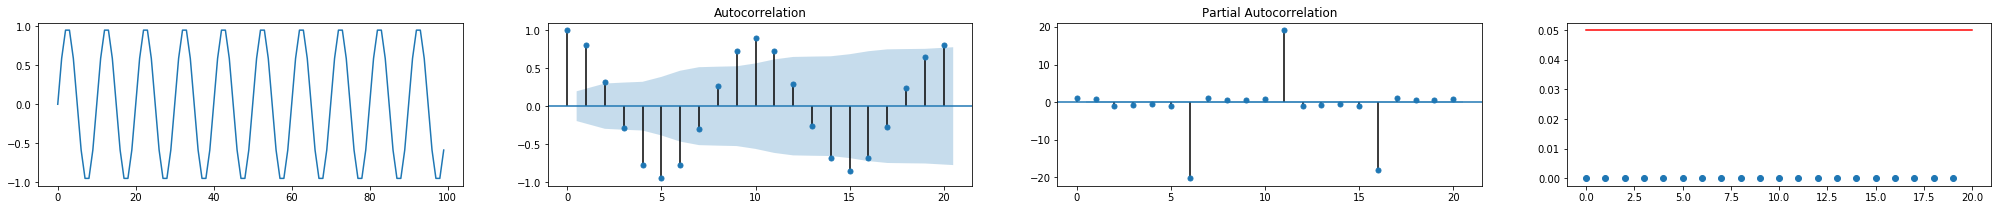

In [0]:
 analyze(np.sin(2*np.pi*0.1*np.arange(100)))

Mann_Kendall_Test(trend='no trend', h=False, p=1.0, z=0, Tau=0.0, s=0.0, var_s=889554000.0, slope=0.0)


(True, 19.676522291522296)

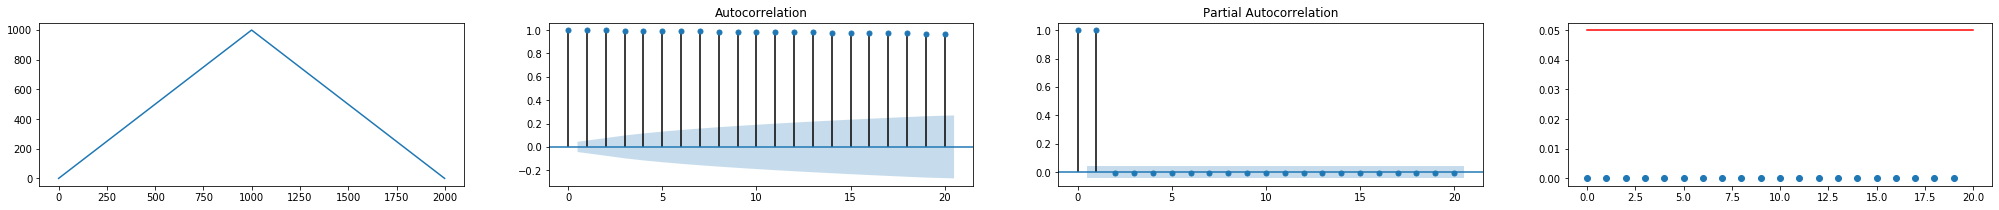

In [0]:
 analyze(np.concatenate([np.arange(1000),np.arange(1000)[::-1]]))

Mann_Kendall_Test(trend='no trend', h=False, p=0.6246652374472268, z=-0.4892492617795887, Tau=-0.010334334334334335, s=-5162.0, var_s=111277500.0, slope=-1.5297312200789543e-05)


(False, 0)

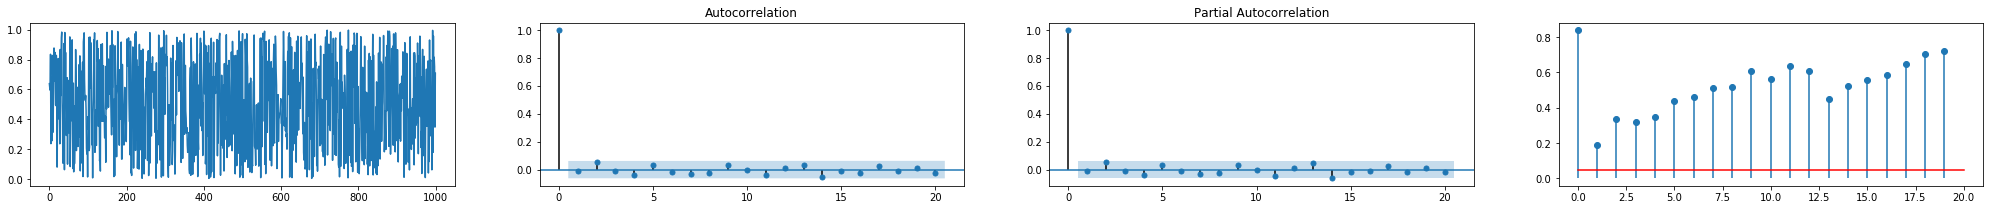

In [0]:
 analyze(np.random.rand(1000))

Mann_Kendall_Test(trend='no trend', h=False, p=0.1920608757725919, z=1.3045067024508663, Tau=0.02755155155155155, s=13762.0, var_s=111277500.0, slope=4.1871886383518815e-05)


(False, 0)

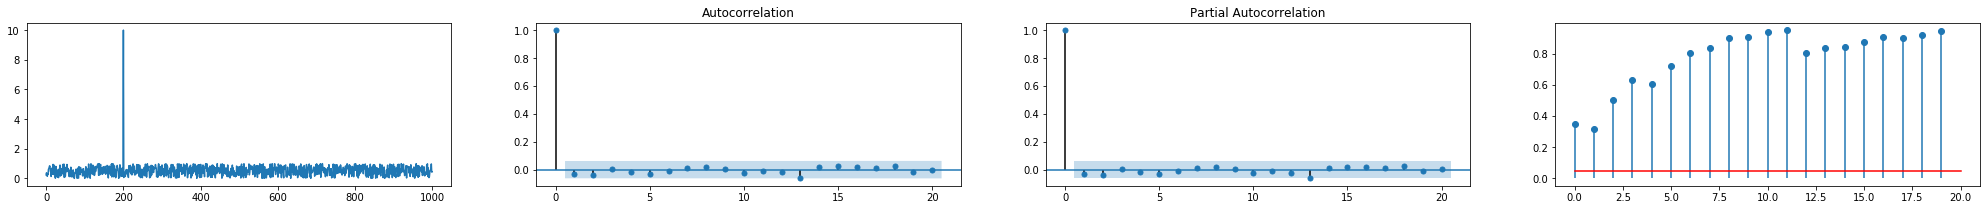

In [0]:
 data = np.random.rand(1000)
 data[200] = 10
 analyze(data)

## Anlayze Databases

### Metro Interstate Traffic

In [0]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv.gz', compression='gzip')
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [0]:
s,r = analyzeDB_attGrouping(df)

Most probable grouping attribute is: holiday


In [0]:
s

,% data,groups,avg_temp_att,std,avg_corr,max_corr
holiday,99,1,4.000000,0.000000,8.589286,17.178572
temp,41,1303,1.192632,0.465749,1.279268,14.062500
rain_1h,98,56,1.678571,0.983927,2.975698,19.179688
snow_1h,99,5,2.000000,0.894427,3.448541,17.179340
clouds_all,99,34,2.147059,0.732937,4.838004,18.470961
weather_main,99,9,3.111111,0.874890,12.540115,18.057473
weather_description,99,24,2.166667,1.105542,8.800022,17.522695
date_time,0,1,1.000000,0.000000,0.416667,0.833333
traffic_volume,12,391,1.122762,0.350766,0.641085,1.127750
no-grouping,100,1,4.000000,0.000000,6.521112,17.181525


To be sure the results are cohorent I go through all attributes to see how they look like and what is their individual result from the test

> Bloc con sangría



Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=35.87119205014844, Tau=0.10892529282342671, s=126548175.0, var_s=12445723483611.0, slope=0.0001506818910454008)


(True, 17.181524524850357)

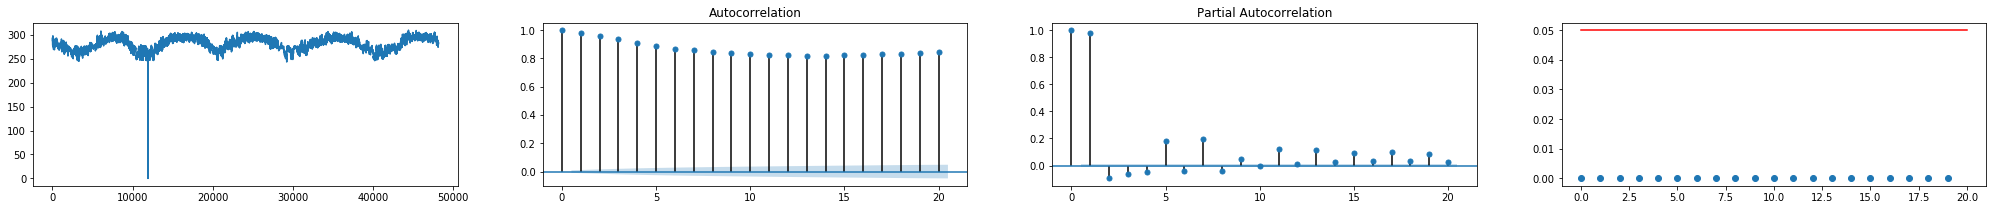

In [0]:
analyze(df["temp"])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-11.904045830542405, Tau=-0.035043459098663333, s=-40713095.0, var_s=11697122425652.334, slope=0.0)


(True, 4.5555072985055425)

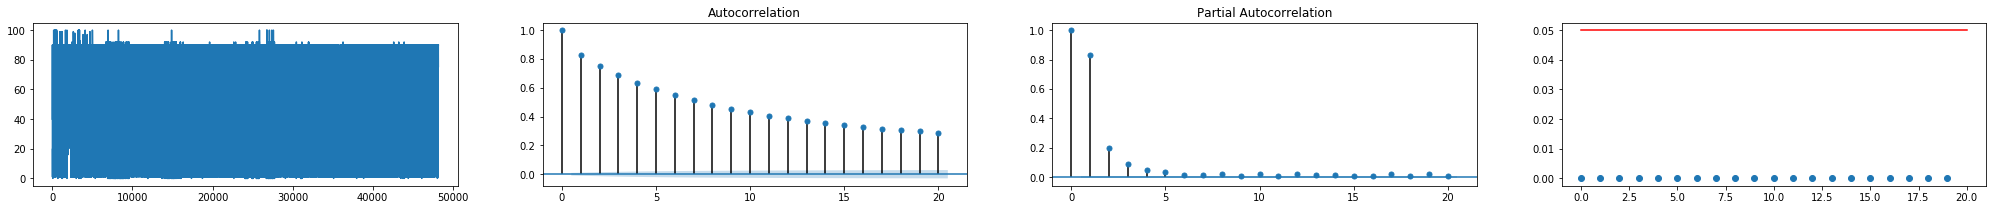

In [0]:
 analyze(df["clouds_all"])

Autocorr =  True
Mann_Kendall_Test(trend='no trend', h=False, p=0.11016574079351615, z=1.5974486255282063, Tau=0.004850761563523066, s=5635560.0, var_s=12445725032542.0, slope=0.0007606876616461281)


(True, 2.237977718586252)

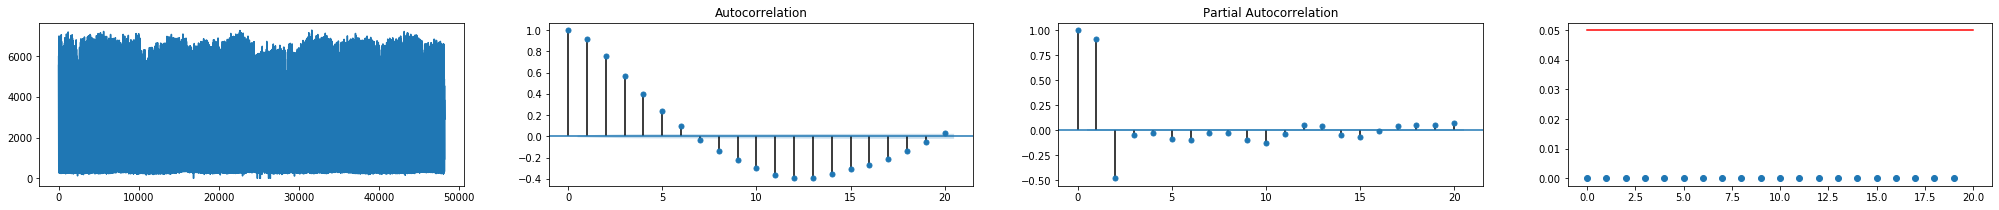

In [0]:
 analyze(df["traffic_volume"])

### Bank marketing

In [0]:
zf = zipfile.ZipFile('bank.zip') 
df = pd.read_csv(zf.open('bank.csv'),sep=';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4516,33,services,married,secondary,no,-333,yes,no,cellular,30,jul,329,5,-1,0,unknown,no
4517,57,self-employed,married,tertiary,yes,-3313,yes,yes,unknown,9,may,153,1,-1,0,unknown,no
4518,57,technician,married,secondary,no,295,no,no,cellular,19,aug,151,11,-1,0,unknown,no
4519,28,blue-collar,married,secondary,no,1137,no,no,cellular,6,feb,129,4,211,3,other,no


In [0]:
analyzeDB_attGrouping(df)

No correlation found


I check that any attribute actually has autocorrelation


Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.6572106867221352, z=0.4437675015623613, Tau=0.0043995278670041285, s=44952.0, var_s=10260481145.333334, slope=0.0)


(False, 0)

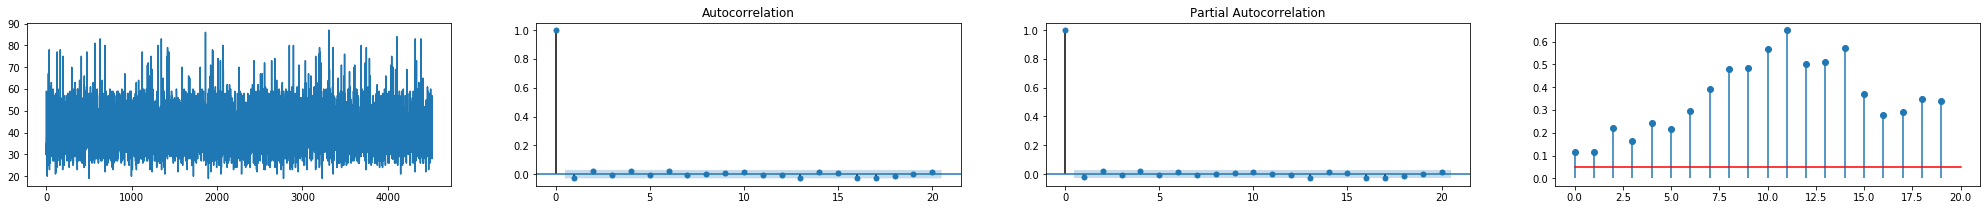

In [0]:
analyze(df['age'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.41288237244101067, z=-0.8188318220776378, Tau=-0.008119924129871808, s=-82965.0, var_s=10265732448.333334, slope=-0.0008514865578953461)


(False, 0)

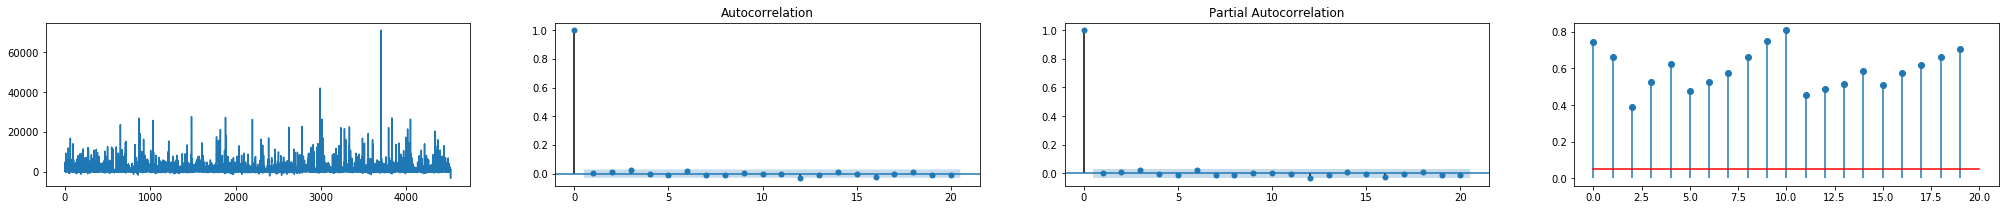

In [0]:
analyze(df['balance'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.8195963261306178, z=0.22806420621655552, Tau=0.002260542248269139, s=23097.0, var_s=10255557693.666666, slope=0.0)


(False, 0)

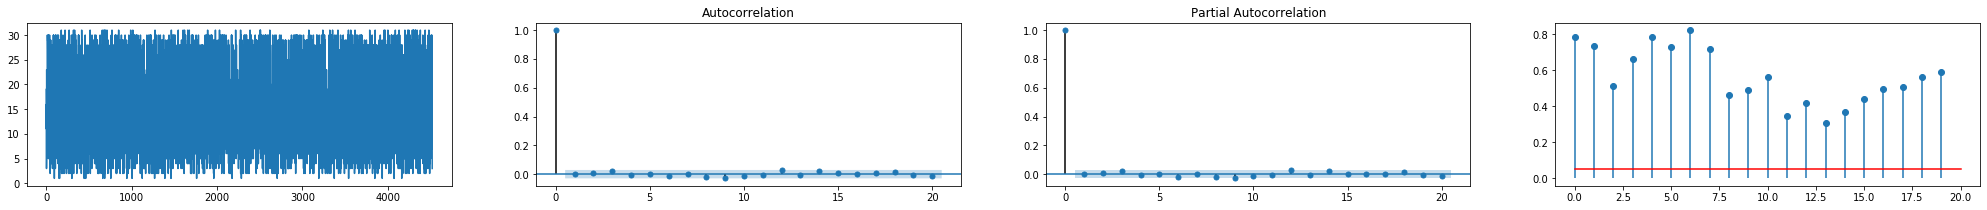

In [0]:
analyze(df['day'])

Autocorr =  True
Mann_Kendall_Test(trend='no trend', h=False, p=0.468596635540089, z=0.7247643081803159, Tau=0.00718887081525154, s=73452.0, var_s=10270742238.0, slope=0.001152073732718894)


(False, 0)

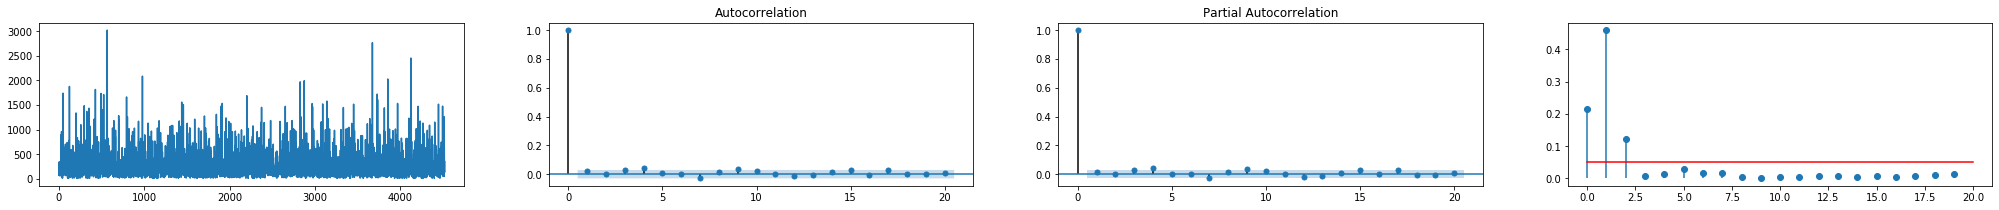

In [0]:
analyze(df['duration'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.36515766221908486, z=0.9055810130653715, Tau=0.008612414435681667, s=87997.0, var_s=9442157611.666666, slope=0.0)


(False, 0)

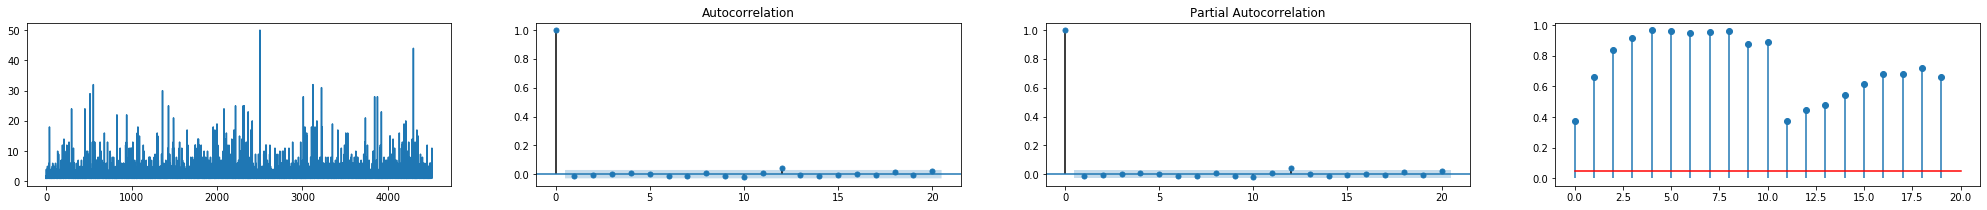

In [0]:
analyze(df['campaign'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.915033421892069, z=-0.10669188348592187, Tau=-0.0007096675690435783, s=-7251.0, var_s=4617567461.666667, slope=0.0)


(False, 0)

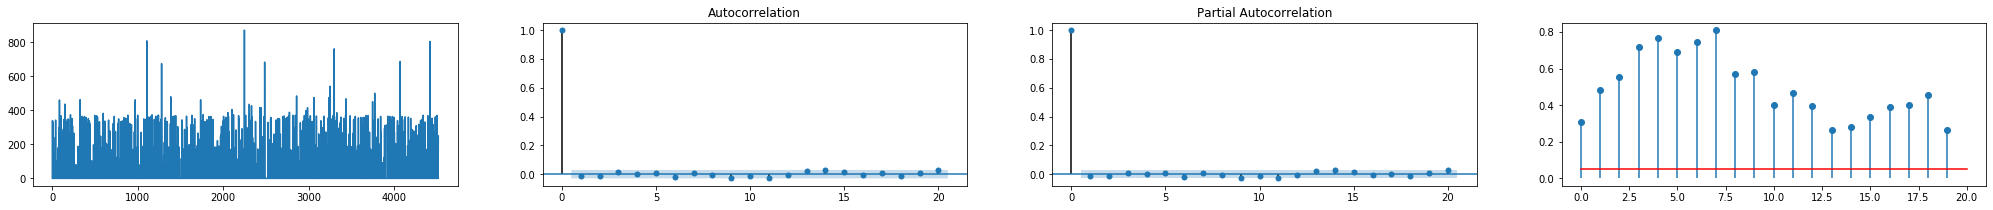

In [0]:
analyze(df['pdays'])

Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.7521094736193961, z=-0.31585907845574623, Tau=-0.0020999348174595253, s=-21456.0, var_s=4613922653.333333, slope=0.0)


(False, 0)

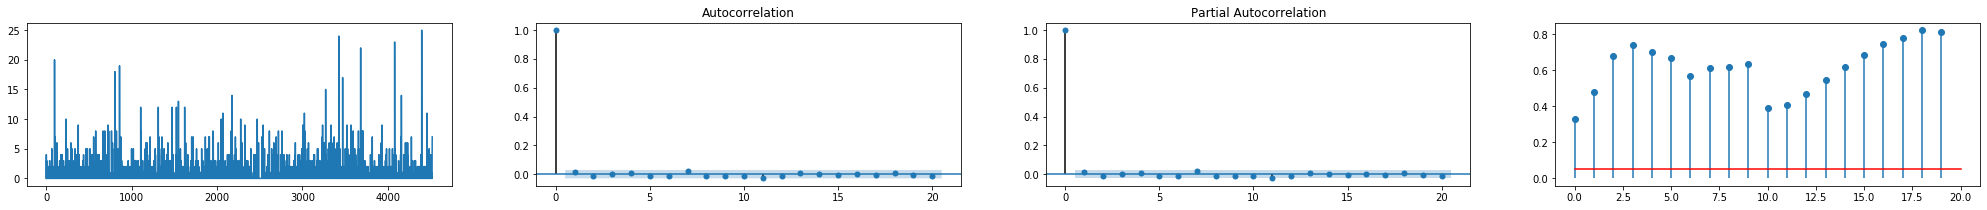

In [0]:
analyze(df['previous'])

### Indian Market

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/MarketArrivals.csv')
df["month"] = df["month"].str.capitalize()
df["month"] = pd.to_datetime(df.month, format='%B', errors='coerce')
df = df.sort_values(by=['year', 'month'])
df

,market,month,year,quantity,priceMin,priceMax,priceMod,state,city,date
5399,LASALGAON(MS),1900-01-01,1996,225063,160,257,226,MS,LASALGAON,January-1996
5420,LASALGAON(MS),1900-02-01,1996,196164,133,229,186,MS,LASALGAON,February-1996
5441,LASALGAON(MS),1900-03-01,1996,178992,155,274,243,MS,LASALGAON,March-1996
5461,LASALGAON(MS),1900-04-01,1996,192592,136,279,254,MS,LASALGAON,April-1996
5481,LASALGAON(MS),1900-05-01,1996,237574,154,312,269,MS,LASALGAON,May-1996
...,...,...,...,...,...,...,...,...,...,...
9610,SURAT(GUJ),1900-02-01,2016,29450,697,1269,983,GUJ,SURAT,February-2016
9799,UDAIPUR(RAJ),1900-02-01,2016,4422,289,1006,656,RAJ,UDAIPUR,February-2016
9920,VANI(MS),1900-02-01,2016,42275,522,1006,688,MS,VANI,February-2016
10004,VARANASI(UP),1900-02-01,2016,17300,1415,1465,1433,UP,VARANASI,February-2016


In [0]:
s, r = analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: city


,% data,groups,avg_temp_att,std,avg_corr,max_corr
market,98,98,4.265306,1.025701,7.597219,17.380627
month,100,12,3.250000,0.433013,17.350342,18.922796
year,88,18,2.111111,0.566558,9.423703,16.693016
quantity,0,3,1.000000,0.000000,0.506559,0.715559
priceMin,43,259,1.193050,0.513702,0.982610,16.380649
priceMax,18,150,1.100000,0.321455,0.781450,2.429405
priceMod,26,204,1.088235,0.300423,0.763984,2.519834
state,99,19,4.263158,0.713929,13.466990,19.762833
city,99,96,4.281250,1.027772,7.757305,17.380627
date,0,5,1.000000,0.000000,0.570747,0.784514


In [0]:
getTemporalAtt(df, r, s)

Threshold = 72.82772001694511


,Ocurrences [%]
year,82.291667
quantity,62.500000
priceMin,92.708333
priceMax,92.708333
priceMod,92.708333


Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.0012015956191748778, z=3.238501089789127, Tau=0.021352727086912725, s=1116548.0, var_s=118868264770.0, slope=0.2599223738575185)


(True, 13.816379332293344)

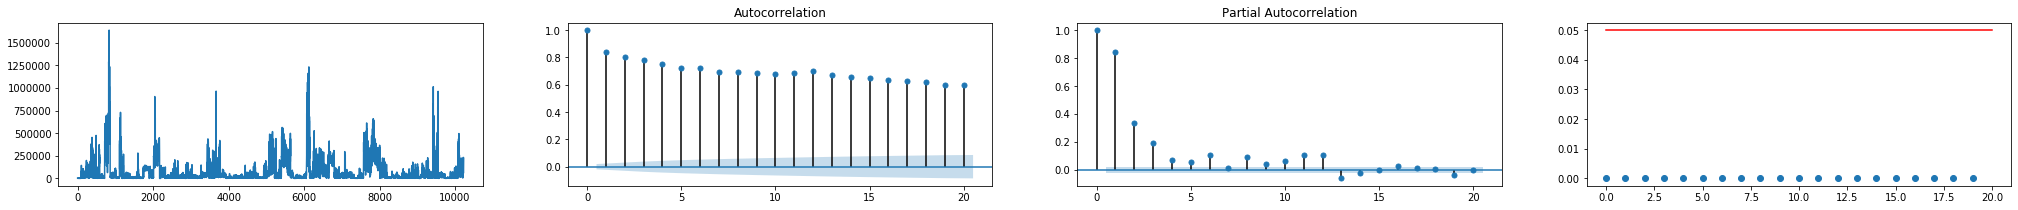

In [0]:
analyze(df['quantity'])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-14.402322871064033, Tau=-0.09495940297243574, s=-4965489.0, var_s=118866311905.0, slope=-0.016775935210181257)


(True, 0.5246258730283888)

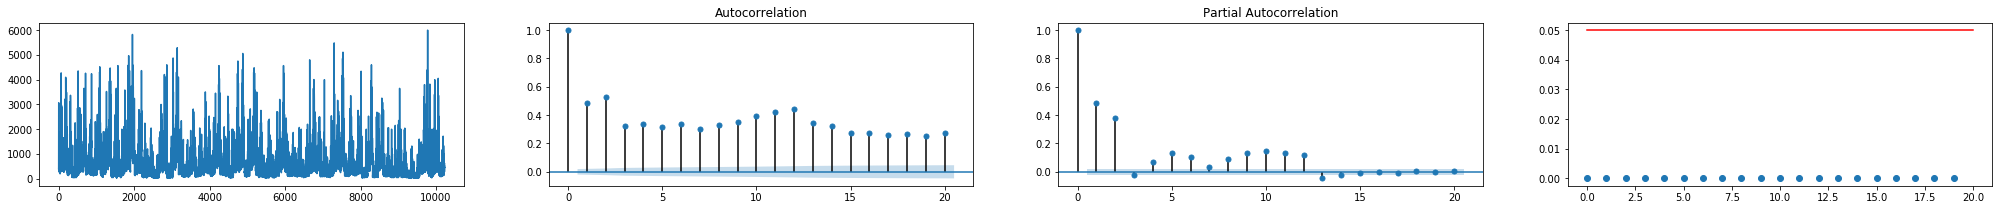

In [0]:
analyze(df['priceMin'])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-8.669383119610437, Tau=-0.057160638524083394, s=-2988967.0, var_s=118868164915.66667, slope=-0.01702530148971388)


(False, 0)

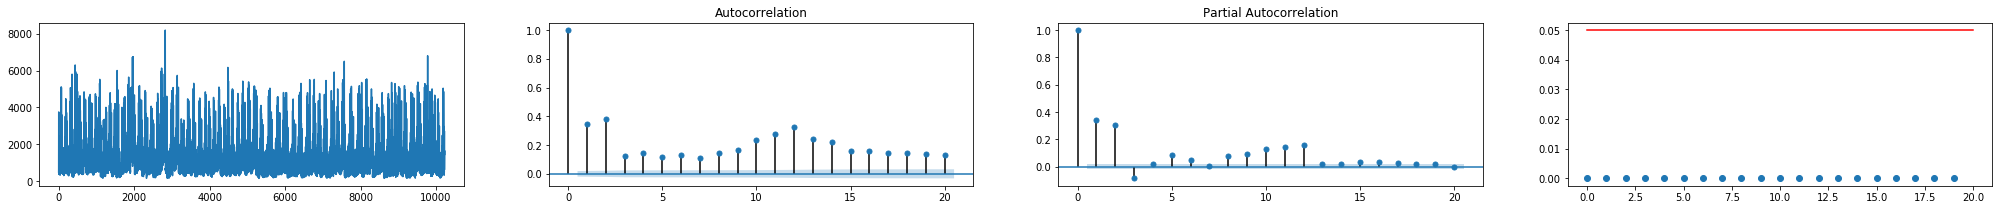

In [0]:
analyze(df['priceMax'])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-9.322353577523456, Tau=-0.06146592055241385, s=-3214093.0, var_s=118868139716.33333, slope=-0.01522035438437074)


(False, 0)

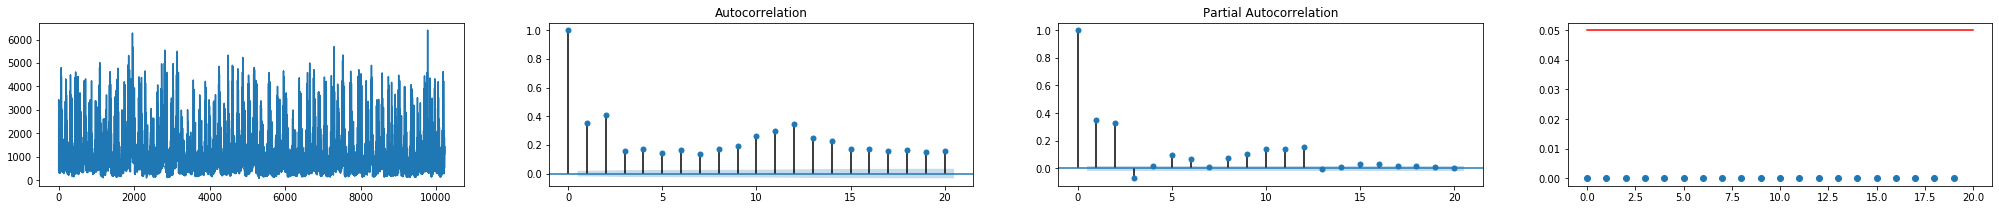

In [0]:
analyze(df['priceMod'])

### UFC Fights

In [0]:
!kaggle datasets download -d rajeevw/ufcdata
zf = zipfile.ZipFile('ufcdata.zip') 
df = pd.read_csv(zf.open('data.csv'),sep=',')
df = df[['R_fighter','B_fighter','date','no_of_rounds','R_age','B_age','R_Weight_lbs','B_Weight_lbs']]
df.dropna()

ufcdata.zip: Skipping, found more recently modified local copy (use --force to force download)


,R_fighter,B_fighter,date,no_of_rounds,R_age,B_age,R_Weight_lbs,B_Weight_lbs
0,Henry Cejudo,Marlon Moraes,2019-06-08,5,32.0,31.0,135.0,135.0
1,Valentina Shevchenko,Jessica Eye,2019-06-08,5,31.0,32.0,125.0,125.0
2,Tony Ferguson,Donald Cerrone,2019-06-08,3,35.0,36.0,155.0,155.0
3,Jimmie Rivera,Petr Yan,2019-06-08,3,29.0,26.0,135.0,135.0
4,Tai Tuivasa,Blagoy Ivanov,2019-06-08,3,26.0,32.0,264.0,250.0
...,...,...,...,...,...,...,...,...
5136,Royce Gracie,Gerard Gordeau,1993-11-12,1,26.0,34.0,175.0,216.0
5138,Royce Gracie,Ken Shamrock,1993-11-12,1,26.0,29.0,175.0,205.0
5140,Ken Shamrock,Patrick Smith,1993-11-12,1,29.0,30.0,205.0,225.0
5141,Royce Gracie,Art Jimmerson,1993-11-12,1,26.0,30.0,175.0,196.0


In [0]:
s,r=analyzeDB_attGrouping(df.dropna())
s

Most probable grouping attribute is: R_Weight_lbs


,% data,groups,avg_temp_att,std,avg_corr,max_corr
R_fighter,32,122,1.229508,0.475410,0.777354,1.636042
B_fighter,7,34,1.147059,0.354165,0.687207,0.833333
date,7,35,1.085714,0.279942,0.636320,0.758162
no_of_rounds,0,0,NaN,NaN,0.000000,0.000000
R_age,0,0,NaN,NaN,0.000000,0.000000
B_age,0,1,1.000000,0.000000,0.291667,0.583333
R_Weight_lbs,2,6,1.333333,0.471405,0.811521,1.388643
B_Weight_lbs,1,6,1.166667,0.372678,0.589221,0.861444
no-grouping,100,1,0.000000,0.000000,0.000000,0.000000


In [0]:
getTemporalAtt(df, r, s, filter_att='R_fighter')

R_fighter
Threshold = -7.708846539423533


,Ocurrences [%]
R_age,95.081967
no_of_rounds,7.377049
B_age,9.016393
B_Weight_lbs,8.196721


Autocorr =  False
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-15.453443222812425, Tau=-0.1442158773272065, s=-1860480.0, var_s=14494359304.0, slope=-0.000598623166716552)


(False, 0)

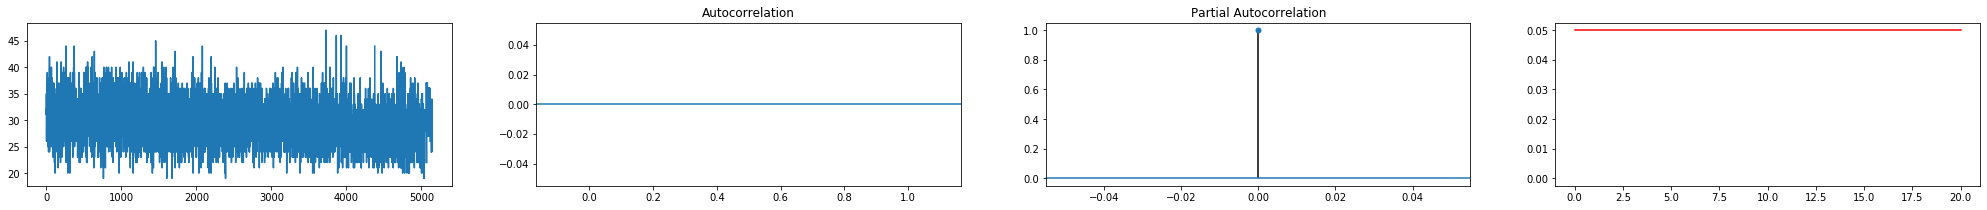

In [0]:
analyze(df['R_age'])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=5.467415409299292e-10, z=-6.205065421043733, Tau=-0.924901185770751, s=-234.0, var_s=1410.0, slope=-0.5)


(True, 1.6360416427670068)

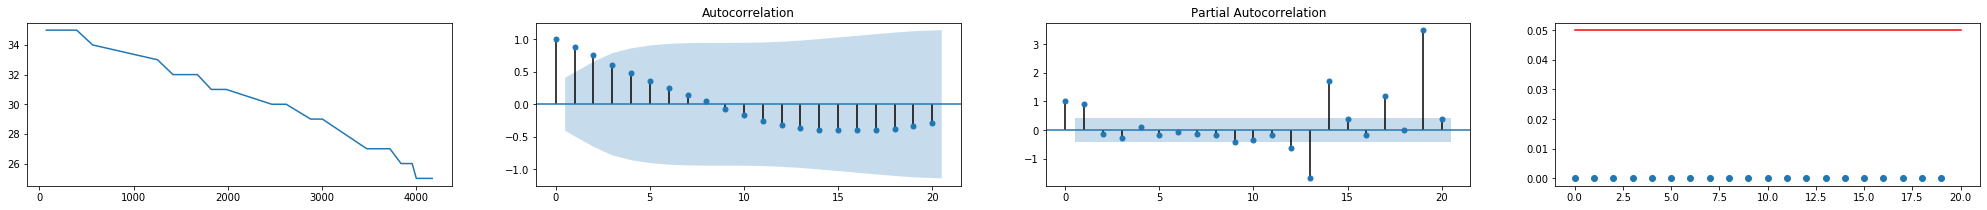

In [0]:
analyze(df.loc[df['R_fighter'] == 'Jim Miller']['R_age'])

### Africa crisis data

In [0]:
!kaggle datasets download -d chirin/africa-economic-banking-and-systemic-crisis-data
zf = zipfile.ZipFile('africa-economic-banking-and-systemic-crisis-data.zip') 
df = pd.read_csv(zf.open('african_crises.csv'),sep=',')
df

401 - Unauthorized


FileNotFoundError: ignored

In [0]:
analyzeDB_attGrouping(df)

Most probable grouping attribute is: no-grouping


,% data,groups,avg_temp_att,std,avg_corr,max_corr
case,100,13,6.000000,1.797434,5.710201,11.973607
cc3,100,13,6.000000,1.797434,5.710201,11.973607
country,100,13,6.000000,1.797434,5.710201,11.973607
year,81,72,1.083333,0.276385,0.758301,0.794278
systemic_crisis,100,2,7.000000,2.000000,8.751689,19.425900
exch_usd,13,9,2.222222,1.685083,1.139047,3.368246
domestic_debt_in_default,100,2,7.500000,1.500000,7.288874,19.423766
sovereign_external_debt_default,100,2,7.500000,0.500000,10.878415,19.345217
gdp_weighted_default,97,2,4.500000,3.500000,6.763414,19.456907
inflation_annual_cpi,1,1,2.000000,0.000000,0.425029,0.850059


Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.025639720065859573, z=2.231625572148704, Tau=0.03305183225606066, s=18516.0, var_s=68834280.0, slope=0.0)


(True, 5.783509256203152)

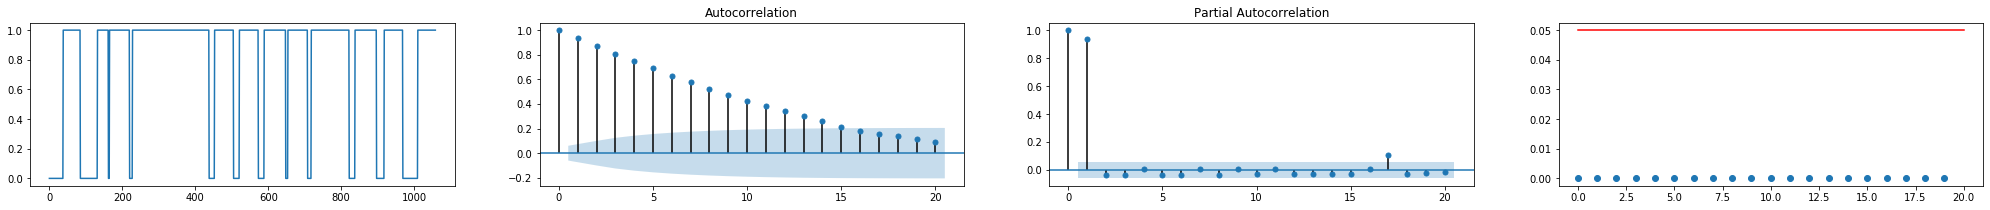

In [0]:
analyze(df['independence'])

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=3.1086244689504383e-15, z=7.888762746546097, Tau=0.5002801120448179, s=1786.0, var_s=51198.666666666664, slope=0.011976477337923121)


(True, 5.99682497859166)

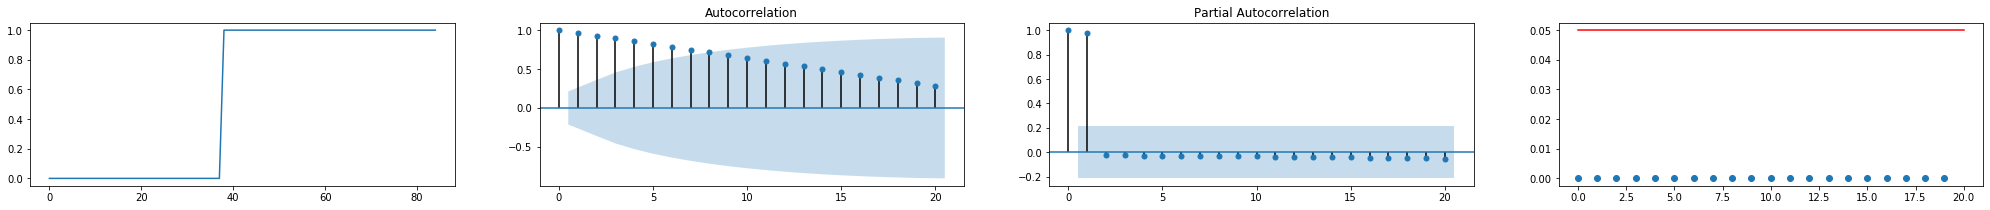

In [0]:
analyze(df.loc[df['country'] == 'Algeria']['independence'])

In [0]:
analyze(df.sort_values(by=['year']))

ValueError: ignored

In [0]:
analyze(df.sort_values(by=['year'])['year'])

In [0]:
t,c = analyzeDB(df) 
print(t)
print(c)

In [0]:
for val in df['country'].unique():
  t,c = analyzeDB(df.loc[df['country'] == val]) 
  print(t)
  print(c)

['year', 'exch_usd', 'sovereign_external_debt_default', 'gdp_weighted_default', 'inflation_annual_cpi', 'independence', 'currency_crises', 'inflation_crises']
[5.746845419697346, 5.836804392478186, 1.4593447505584511, 1.459344750558452, 0.62044503034621, 5.99682497859166, 0.5015307877536983, 0.5701148064859747]
['year', 'exch_usd', 'domestic_debt_in_default', 'sovereign_external_debt_default', 'inflation_annual_cpi', 'independence', 'currency_crises', 'inflation_crises']
[6.005154413660109, 3.9243876256935737, 2.097152847152847, 3.048139360639361, 0.5716145179753153, 5.834558349451964, 2.3354037267080736, 2.96848249789426]
['year', 'systemic_crisis', 'exch_usd', 'sovereign_external_debt_default', 'independence']
[4.2262911809037496, 2.0103308669551856, 3.1162562608294344, 4.133772204806688, 0.6657262277951933]
['year', 'systemic_crisis', 'exch_usd', 'sovereign_external_debt_default', 'independence']
[5.003360215053764, 0.73197471078827, 2.185331867536757, 3.6954988892108567, 2.23614718

### European social survey

In [0]:
!kaggle datasets download -d pascalbliem/european-social-survey-ess-8-ed21-201617
zf = zipfile.ZipFile('european-social-survey-ess-8-ed21-201617.zip') 
df = pd.read_csv(zf.open('ESS8e02.1_F1.csv'),sep=',')

 48% 5.00M/10.3M [00:00<00:00, 10.1MB/s]
100% 10.3M/10.3M [00:00<00:00, 19.1MB/s]


In [0]:
df

,name,essround,edition,proddate,idno,cntry,nwspol,netusoft,netustm,ppltrst,pplfair,pplhlp,polintr,psppsgva,actrolga,psppipla,cptppola,trstprl,trstlgl,trstplc,trstplt,trstprt,trstep,trstun,vote,prtvtbat,prtvtcbe,prtvtfch,prtvtdcz,prtvede1,prtvede2,prtvtfee,prtvtdes,prtvtdfi,prtvtcfr,prtvtbgb,prtvtehu,prtvtbie,prtvtcil,prtvtbis,...,anctry1,anctry2,ipcrtiv,imprich,ipeqopt,ipshabt,impsafe,impdiff,ipfrule,ipudrst,ipmodst,ipgdtim,impfree,iphlppl,ipsuces,ipstrgv,ipadvnt,ipbhprp,iprspot,iplylfr,impenv,imptrad,impfun,region,regunit,intewde,inwdds,inwmms,inwyys,inwshh,inwsmm,inwdde,inwmme,inwyye,inwehh,inwemm,inwtm,dweight,pspwght,pweight
0,ESS8e02_1,8,2.1,01.12.2018,1,AT,120,4,180,8,8,3,1,2,2,2,3,6,7,0,2,8,9,10,3,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11070,555555,2,6,1,2,2,3,5,1,2,4,3,1,2,6,3,6,1,1,1,6,3,AT13,2,NaN,5,12,2016,7,37,5,12,2016,8,33,50.0,0.611677,1.178496,0.370393
1,ESS8e02_1,8,2.1,01.12.2018,2,AT,120,5,120,6,6,5,1,1,3,2,3,5,4,3,3,4,6,7,3,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11070,555555,3,6,2,3,5,3,5,3,4,3,2,3,3,4,5,5,2,2,2,5,5,AT13,2,NaN,25,11,2016,9,39,25,11,2016,11,10,86.0,1.223354,0.899472,0.370393
2,ESS8e02_1,8,2.1,01.12.2018,4,AT,30,2,6666,5,6,4,3,2,2,2,2,3,5,9,3,3,4,5,1,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11010,555555,3,5,2,4,1,6,5,2,3,2,2,3,6,1,6,3,3,1,2,2,3,AT31,2,NaN,22,11,2016,17,17,22,11,2016,18,0,38.0,0.389058,0.315753,0.370393
3,ESS8e02_1,8,2.1,01.12.2018,6,AT,30,5,120,6,5,6,2,3,2,3,4,1,1,2,1,1,1,1,7,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11010,555555,2,3,2,2,2,3,3,2,2,2,2,3,3,2,3,4,2,2,3,2,2,AT13,2,NaN,11,10,2016,19,9,11,10,2016,19,59,46.0,0.642594,0.472467,0.370393
4,ESS8e02_1,8,2.1,01.12.2018,10,AT,30,5,180,5,5,7,3,3,3,4,1,7,7,10,6,7,9,10,2,66.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,23000,555555,3,4,1,4,3,3,5,3,1,1,1,1,3,4,5,2,3,1,1,4,1,AT22,2,NaN,1,12,2016,10,31,1,12,2016,11,49,70.0,3.432402,2.246706,0.370393
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44382,ESS8e02_1,8,2.1,01.12.2018,1303,SI,90,2,6666,1,2,1,2,1,4,1,4,0,0,3,0,0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14120,555555,1,2,3,2,1,1,5,4,2,1,1,1,1,1,1,2,2,1,2,1,1,SI016,3,NaN,19,10,2016,7,30,19,10,2016,8,37,62.0,1.000000,0.835442,0.134491
44383,ESS8e02_1,8,2.1,01.12.2018,1304,SI,40,5,120,3,5,2,2,2,2,1,2,0,0,2,0,1,5,5,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14030,555555,1,4,2,2,2,3,2,2,3,3,1,1,1,1,4,1,2,1,1,1,2,SI011,3,NaN,30,9,2016,8,38,30,9,2016,9,45,60.0,1.000000,0.756328,0.134491
44384,ESS8e02_1,8,2.1,01.12.2018,1305,SI,240,5,150,3,3,4,2,2,2,1,2,3,5,9,1,1,2,5,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14120,555555,2,6,1,1,1,2,1,2,1,4,1,2,2,2,4,1,1,2,1,2,5,SI011,3,NaN,26,9,2016,9,9,26,9,2016,10,17,62.0,1.000000,0.856172,0.134491
44385,ESS8e02_1,8,2.1,01.12.2018,1306,SI,0,5,120,5,5,5,3,2,5,2,5,1,6,5,1,1,1,3,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14120,555555,2,3,2,2,2,1,5,2,2,1,1,1,1,1,2,3,1,3,2,4,1,SI011,3,NaN,2,11,2016,17,0,2,11,2016,18,25,78.0,1.000000,0.756328,0.134491


In [0]:
analyzeDB_attGrouping(df) 

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=4.218847493575595e-14, z=-7.553738775492829, Tau=-0.02115586285509681, s=-20840232.0, var_s=7611690712742.0, slope=0.0)


(False, 0)

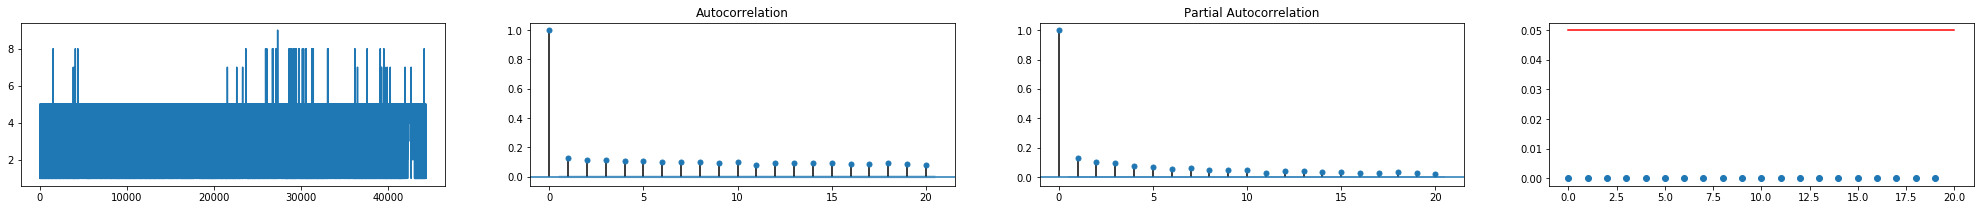

In [0]:
analyze(df['netusoft'])

### India trade data

In [0]:
!kaggle datasets download -d lakshyaag/india-trade-data
zf = zipfile.ZipFile('india-trade-data.zip') 
df = pd.read_csv(zf.open('2018-2010_export.csv'),sep=',')
df

  0% 0.00/1.46M [00:00<?, ?B/s]
100% 1.46M/1.46M [00:00<00:00, 95.2MB/s]


,HSCode,Commodity,value,country,year
0,2,MEAT AND EDIBLE MEAT OFFAL.,0.18,AFGHANISTAN TIS,2018
1,3,"FISH AND CRUSTACEANS, MOLLUSCS AND OTHER AQUAT...",0.00,AFGHANISTAN TIS,2018
2,4,DAIRY PRODUCE; BIRDS' EGGS; NATURAL HONEY; EDI...,12.48,AFGHANISTAN TIS,2018
3,6,LIVE TREES AND OTHER PLANTS; BULBS; ROOTS AND ...,0.00,AFGHANISTAN TIS,2018
4,7,EDIBLE VEGETABLES AND CERTAIN ROOTS AND TUBERS.,1.89,AFGHANISTAN TIS,2018
...,...,...,...,...,...
137018,95,"TOYS, GAMES AND SPORTS REQUISITES; PARTS AND A...",0.03,ZIMBABWE,2010
137019,96,MISCELLANEOUS MANUFACTURED ARTICLES.,0.45,ZIMBABWE,2010
137020,97,WORKS OF ART COLLECTORS' PIECES AND ANTIQUES.,0.00,ZIMBABWE,2010
137021,98,PROJECT GOODS; SOME SPECIAL USES.,0.00,ZIMBABWE,2010


In [0]:
t,c = analyzeDB(df) 
print(t)
print(c)

['HSCode', 'year']
[4.394116490855901, 19.99539494914013]


Autocorr =  False
Mann_Kendall_Test(trend='no trend', h=False, p=0.7879780779284882, z=-0.2689371113746626, Tau=-0.007138776422663255, s=-1437.0, var_s=28510669.0, slope=-4.587155963302753e-05)


(False, 0)

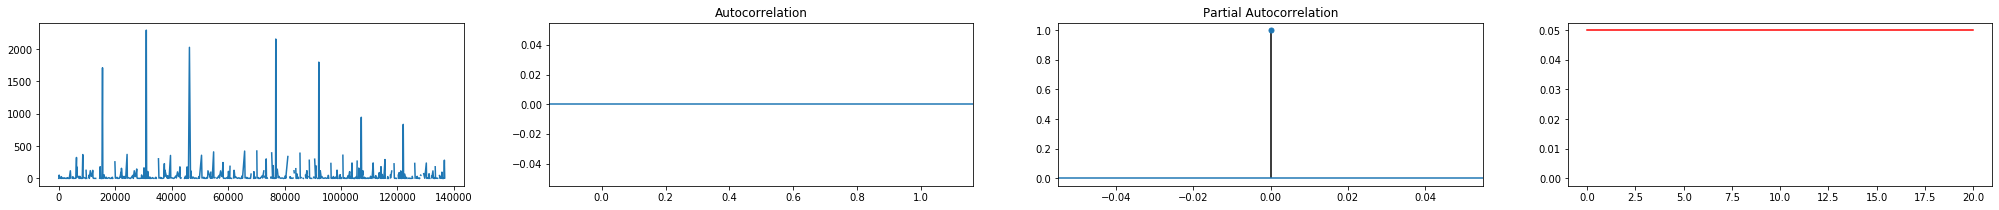

In [0]:
analyze(df.loc[df['Commodity'] == 'MEAT AND EDIBLE MEAT OFFAL.']['value'])

Autocorr =  True
Mann_Kendall_Test(trend='decreasing', h=True, p=0.0, z=-36.48720667971042, Tau=-0.8886571160117974, s=-244961.0, var_s=45072237.0, slope=-0.012048192771084338)


(True, 19.179853042884258)

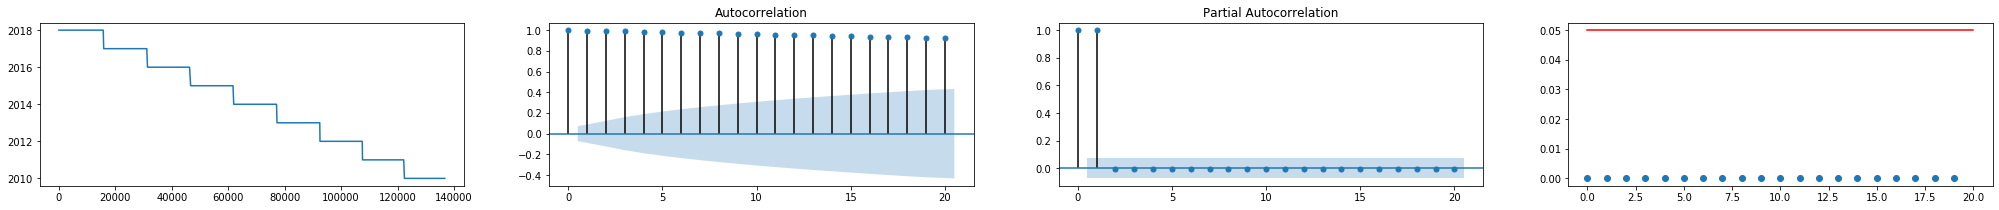

In [0]:
analyze(df.loc[df['Commodity'] == 'MEAT AND EDIBLE MEAT OFFAL.']['year'])

### New York Airbnb

In [0]:
!kaggle datasets download -d dgomonov/new-york-city-airbnb-open-data
zf = zipfile.ZipFile('new-york-city-airbnb-open-data.zip') 
df = pd.read_csv(zf.open('AB_NYC_2019.csv'),sep=',')
df

new-york-city-airbnb-open-data.zip: Skipping, found more recently modified local copy (use --force to force download)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48890,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70,2,0,NaN,NaN,2,9
48891,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40,4,0,NaN,NaN,2,36
48892,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115,10,0,NaN,NaN,1,27
48893,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55,1,0,NaN,NaN,6,2


In [0]:
t,c = analyzeDB(df) 
print(t)
print(c)

['id', 'calculated_host_listings_count']
[19.98812496775153, 1.0813046312580794]


In [0]:
analyzeDB_attGrouping(df)

### Avocado prices


In [0]:
!kaggle datasets download -d neuromusic/avocado-prices
zf = zipfile.ZipFile('avocado-prices.zip') 
df = pd.read_csv(zf.open('avocado.csv'),sep=',')
df

  0% 0.00/629k [00:00<?, ?B/s]
100% 629k/629k [00:00<00:00, 42.6MB/s]


,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,7,2018-02-04,1.63,17074.83,2046.96,1529.20,0.00,13498.67,13066.82,431.85,0.0,organic,2018,WestTexNewMexico
18245,8,2018-01-28,1.71,13888.04,1191.70,3431.50,0.00,9264.84,8940.04,324.80,0.0,organic,2018,WestTexNewMexico
18246,9,2018-01-21,1.87,13766.76,1191.92,2452.79,727.94,9394.11,9351.80,42.31,0.0,organic,2018,WestTexNewMexico
18247,10,2018-01-14,1.93,16205.22,1527.63,2981.04,727.01,10969.54,10919.54,50.00,0.0,organic,2018,WestTexNewMexico


In [0]:
analyzeDB_attGrouping(df)

Most probable grouping attribute is: type


,% data,groups,avg_temp_att,std,avg_corr,max_corr
Unnamed: 0,100,53,1.811321,0.391254,14.814575,16.208333
Date,54,92,1.000000,0.000000,2.916053,7.373611
AveragePrice,97,182,2.835165,2.157347,8.431712,18.960396
Total Volume,0,0,NaN,NaN,0.000000,0.000000
4046,1,2,4.500000,3.500000,5.454174,15.646484
4225,0,1,7.000000,0.000000,2.082349,4.164697
4770,30,2,5.000000,4.000000,6.891118,19.840022
Total Bags,0,1,1.000000,0.000000,0.272849,0.545697
Small Bags,1,6,1.833333,1.863390,1.787197,8.949424
Large Bags,15,13,2.769231,2.606319,4.250413,19.217684


In [0]:
d = analyzeDB_attGrouping(df)

In [0]:
import copy
d1 = copy.deepcopy(d)
mx = 0
for key, value in d.items():
  l = []
  for key2, value2 in value.items():
    l = np.append(l, len(value2))
    #print(np.mean(l), np.std(l))
    if mx < np.mean(l):
      gc = key
      mx = np.mean(l)
  d1[key] = [len(l), np.mean(l), np.std(l)]
print("Most probable grouping attribute is",gc)

Most probable grouping attribute is type


In [0]:
d1

{'4046': [2, 4.5, 3.5],
 '4225': [1, 7.0, 0.0],
 '4770': [2, 5.0, 4.0],
 'AveragePrice': [182, 2.8351648351648353, 2.1573474568906246],
 'Date': [92, 1.0, 0.0],
 'Large Bags': [13, 2.769230769230769, 2.6063191301688335],
 'Small Bags': [6, 1.8333333333333333, 1.8633899812498245],
 'Total Bags': [1, 1.0, 0.0],
 'Total Volume': [0, nan, nan],
 'Unnamed: 0': [53, 1.8113207547169812, 0.3912536104401457],
 'XLarge Bags': [5, 3.6, 3.3823069050575527],
 'region': [54, 10.907407407407407, 0.28986066374997277],
 'type': [2, 11.0, 0.0],
 'year': [4, 10.0, 0.0]}

### Suicide Rates

In [0]:
!kaggle datasets download -d russellyates88/suicide-rates-overview-1985-to-2016
zf = zipfile.ZipFile('suicide-rates-overview-1985-to-2016.zip') 
df = pd.read_csv(zf.open('master.csv'),sep=',')
df


suicide-rates-overview-1985-to-2016.zip: Skipping, found more recently modified local copy (use --force to force download)


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers
...,...,...,...,...,...,...,...,...,...,...,...,...
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.96,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.58,Uzbekistan2014,0.675,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.17,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.67,Uzbekistan2014,0.675,"63,067,077,179",2309,Generation Z


In [0]:
s,r=analyzeDB_attGrouping(df)
s

Most probable grouping attribute is: sex


,% data,groups,avg_temp_att,std,avg_corr,max_corr
country,99,100,4.120000,0.908625,15.716686,18.707829
year,100,32,3.656250,0.474959,3.933790,5.003017
sex,100,2,5.000000,0.000000,11.768788,17.653182
age,100,6,4.833333,0.372678,13.555234,16.326090
suicides_no,58,82,1.378049,0.709521,0.986278,14.369190
population,0,0,NaN,NaN,0.000000,0.000000
suicides/100k pop,41,550,1.163636,0.495934,1.210801,14.369190
country-year,81,1896,1.396097,0.576221,0.743415,0.916667
HDI for year,29,297,3.585859,1.589169,2.281870,9.345238
gdp_for_year ($),81,1896,1.396097,0.576221,0.743415,0.916667


In [0]:
getTemporalAtt(df, r, s)

Threshold = 50.0


,Ocurrences [%]
year,50.0
suicides_no,50.0
population,50.0
suicides/100k pop,50.0
gdp_per_capita ($),50.0


In [0]:
getTemporalAtt(df, r, s, filter_att='no-grouping')

no-grouping


KeyError: ignored

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=2.882092605682729e-06, z=4.679048505847052, Tau=0.026437138721190665, s=2557452.0, var_s=298744245324.0, slope=0.0)


(True, 11.718620218551335)

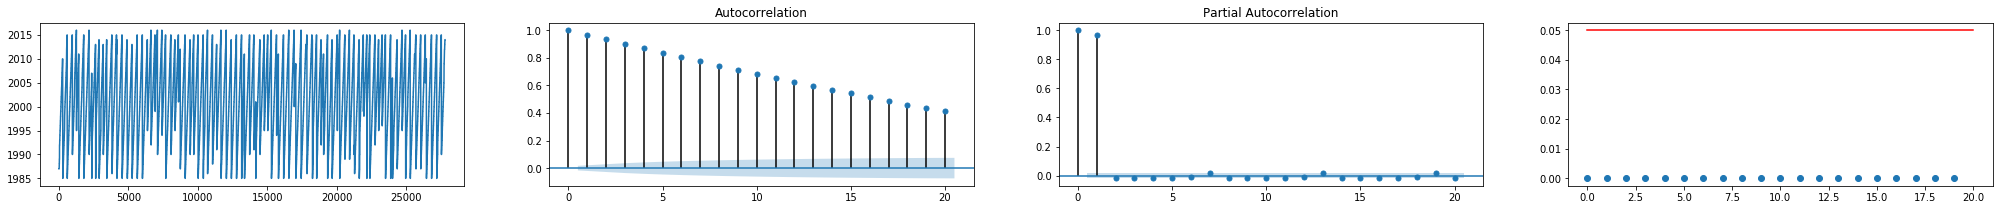

In [0]:
analyze(df.loc[df['sex'] == 'male']['year'])

Autocorr =  True
Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=27.957304861448364, Tau=0.9703504043126685, s=66960.0, var_s=5736240.0, slope=0.08333333333333333)


(True, 18.30766129032258)

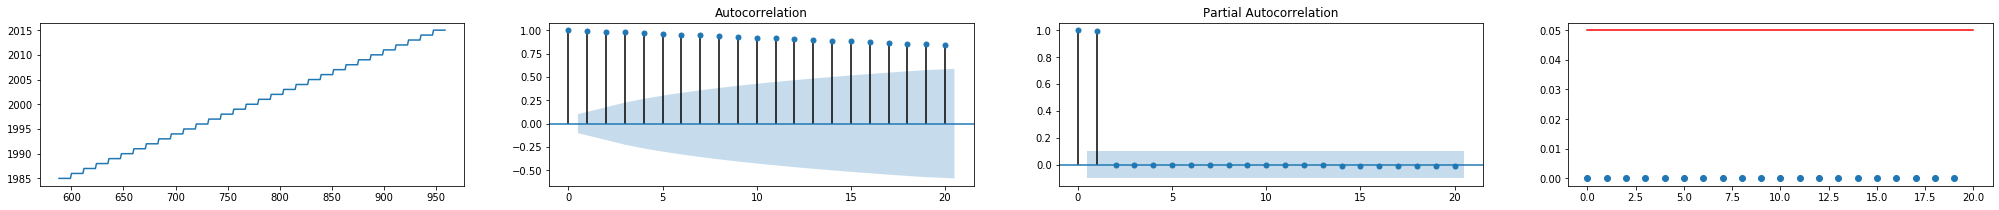

In [0]:
analyze(df.loc[df['country'] == 'Argentina']['year'])

In [0]:
s,r = analyzeDB_attGrouping(df)

Most probable grouping attribute is: sex


In [0]:
r['sex']

{'female': [['year',
   'suicides_no',
   'population',
   'suicides/100k pop',
   'gdp_per_capita ($)'],
  [11.718620218551335,
   7.260126940506864,
   15.069670342348571,
   2.432282163527681,
   17.65318222834171]],
 'male': [['year',
   'suicides_no',
   'population',
   'suicides/100k pop',
   'gdp_per_capita ($)'],
  [11.718620218551335,
   6.657135594193609,
   14.416712708874734,
   2.6331665731068243,
   17.65318222834171]]}

In [0]:
r['country']

In [0]:
len(df.loc[df['country'] == 'Argentina'])

372

In [0]:
analyze(df.loc[df['country'] == 'Albania']['suicides_no'])

### Swedish motor insurance

In [0]:
!kaggle datasets download -d floser/swedish-motor-insurance
zf = zipfile.ZipFile('swedish-motor-insurance.zip') 
df = pd.read_csv(zf.open('SwedishMotorInsurance.csv'),sep=',')
s,r = analyzeDB_attGrouping(df)


swedish-motor-insurance.zip: Skipping, found more recently modified local copy (use --force to force download)
Most probable grouping attribute is: Bonus


In [0]:
s

,% data,groups,avg_temp_att,std,avg_corr,max_corr
Kilometres,100,5,3.600000,0.800000,15.448184,18.571429
Zone,100,7,3.428571,0.728431,15.717367,18.000000
Bonus,100,7,6.000000,0.000000,15.720578,18.000000
Make,100,9,5.888889,0.314270,15.646278,17.428571
Insured,0,0,NaN,NaN,0.000000,0.000000
Claims,79,29,1.379310,0.551724,3.706293,18.281354
Payment,18,2,2.000000,1.000000,6.630961,18.281354
no-grouping,100,1,5.000000,0.000000,8.806800,19.709571


### CDC Kenya insecticides

In [0]:
!kaggle datasets download -d cdc/pone-d-15-23803
zf = zipfile.ZipFile('pone-d-15-23803.zip') 
df = pd.read_csv(zf.open('pone-d-15-23803.csv'),sep=',')
s,r = analyzeDB_attGrouping(df)

  0% 0.00/198k [00:00<?, ?B/s]
100% 198k/198k [00:00<00:00, 62.3MB/s]
Most probable grouping attribute is: SURVEY


In [0]:
s

,% data,groups,avg_temp_att,std,avg_corr,max_corr
SURVEY,100,3,3.000000,0.000000,11.253046,15.266000
DISTRICT,100,2,3.000000,0.000000,1.830608,2.785314
ENUMERATION_AREA,99,170,1.647059,0.477885,2.521743,8.907344
CPNO_NEW,25,103,1.427184,0.513922,0.783082,2.754789
HOUSEID_NEW,0,3,1.000000,0.000000,0.582609,0.808209
HOUSE_TYPE,98,3,3.000000,0.000000,1.367800,2.681993
EAVES_OPEN,98,2,3.000000,0.000000,1.374497,2.752809
TOTALNUMOFNETS,100,7,2.000000,0.000000,1.637148,5.263745
NETS_IN_HOUSE,100,2,2.500000,0.500000,1.150073,2.060931
IRS,98,2,3.000000,0.000000,1.809836,2.721557
